In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support

from IPython.display import HTML

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(palette = "Set2")

In [2]:
def update_plot_params():
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    
update_plot_params()

## CLUSTERING 

In [4]:
data, _ = arff.loadarff('data/raw/landsat.arff.txt')
landsat = pd.DataFrame(data)

In [5]:
landsat['class'] = landsat['class'].str.decode('utf-8')

In [6]:
landsat['class'].value_counts()

1    1072
7    1038
3     961
2     479
5     470
4     415
Name: class, dtype: int64

In [7]:
Y = landsat.pop('class')
X = landsat

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

### K-means 

In [9]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(x_train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [10]:
kmeans_pred = kmeans.predict(x_test)

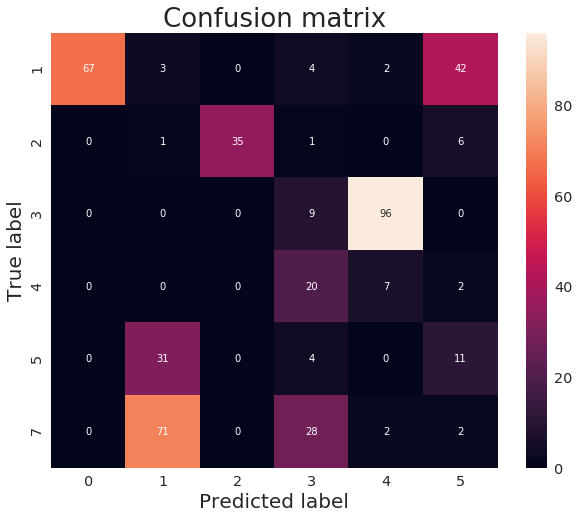

In [11]:
df = pd.DataFrame({'Labels': y_test, 'Clusters': kmeans_pred})
kmeans_conf_matrix = pd.crosstab(df['Labels'], df['Clusters'])

sns.heatmap(kmeans_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

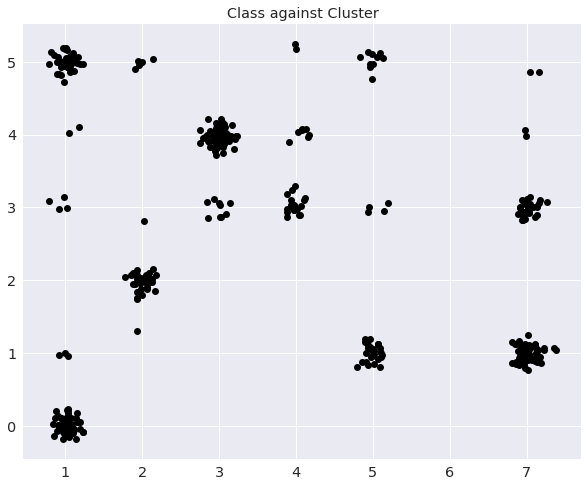

In [12]:
noise1 = np.random.normal(0,0.1,df.shape[0])
noise2 = np.random.normal(0,0.1,df.shape[0])
noise = [[x, y] for x, y in zip(noise1, noise2)]

df = df.astype(int)
df = pd.DataFrame(df.values + noise, columns=df.columns, index=df.index)
plt.plot(df['Labels'], df['Clusters'], 'ko')
plt.title('Class against Cluster')
plt.show()

### PCA 

In [13]:
pca = PCA(n_components=2).fit(X)
components = pca.transform(X)

In [14]:
cm = ListedColormap(sns.color_palette("RdYlGn", 30).as_hex())
styles = [
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

In [15]:
results = (pd.DataFrame(pca.components_,columns=X.columns,index = ['PC1','PC2']).T.style\
        .set_table_styles(styles)
        .background_gradient(cmap=cm))
print('Correlation between a particular pair of component and feature')
display(results)

Correlation between a particular pair of component and feature


,PC1,PC2
pixel1_1,0.136017,-0.0710743
pixel1_2,0.26742,-0.0929943
pixel1_3,0.128321,0.172735
pixel1_4,0.0474384,0.24724
pixel2_1,0.138437,-0.0708321
pixel2_2,0.272107,-0.0931385
pixel2_3,0.130706,0.177344
pixel2_4,0.0485683,0.253178
pixel3_1,0.134769,-0.0692456
pixel3_2,0.26457,-0.091074


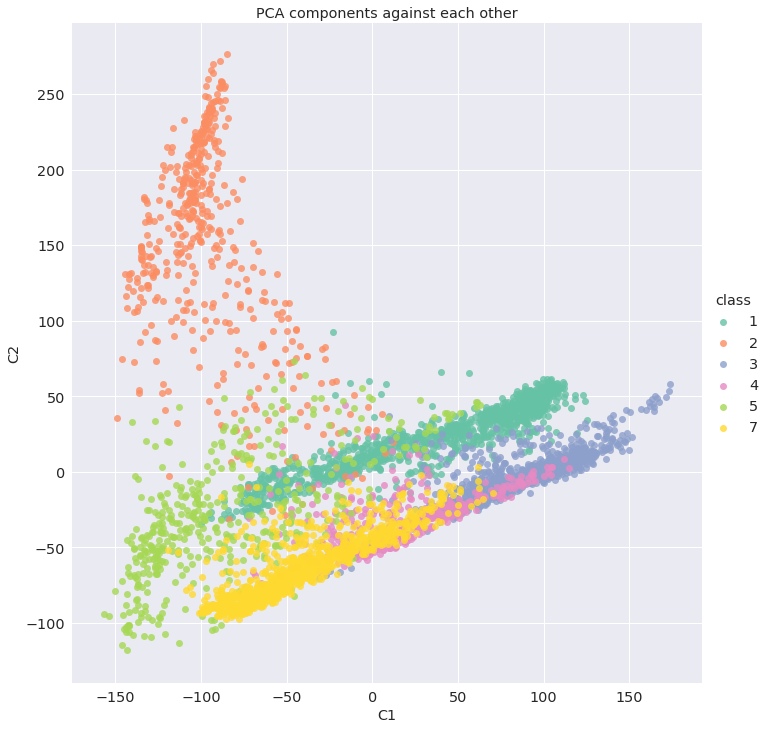

In [16]:
df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df = pd.concat([df, Y], axis=1)

sns.lmplot(x='PC1', y='PC2', data=df, hue='class', fit_reg=False, size=10)
plt.title('PCA components against each other')
plt.show()

### Naive Bayes 

Train on PC:

In [17]:
naive_bayes = GaussianNB()

In [18]:
scores = cross_validate(naive_bayes, pd.DataFrame(components), Y, 
                        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], 
                        cv=5, return_train_score=True)                 

In [19]:
df = pd.DataFrame(scores)
df = df.append(df.mean(axis=0), ignore_index=True)
df.index.name = 'n_folds'
df.index = df.index + 1
df = df.rename(index={6: 'Mean'})

In [20]:
results = (df.T.style.set_table_styles(styles))
results

n_folds,1,2,3,4,5,Mean
fit_time,0.00725508,0.00703812,0.00705385,0.00701475,0.00701332,0.00707502
score_time,0.0119913,0.0118837,0.0117552,0.0119178,0.011945,0.0118986
test_accuracy,0.84027,0.842342,0.80947,0.698646,0.715254,0.781196
test_f1_macro,0.811767,0.816178,0.754309,0.68141,0.674318,0.747596
test_precision_macro,0.853177,0.840857,0.768691,0.695857,0.692243,0.770165
test_recall_macro,0.797759,0.802856,0.75332,0.679236,0.670609,0.740756
train_accuracy,0.778624,0.778404,0.775648,0.804734,0.810141,0.78951
train_f1_macro,0.739735,0.738846,0.747299,0.771375,0.78143,0.755737
train_precision_macro,0.748084,0.752239,0.757795,0.779879,0.788706,0.76534
train_recall_macro,0.733204,0.729747,0.740866,0.764657,0.776226,0.74894


Train on original data frame:

In [21]:
naive_bayes = GaussianNB()

In [22]:
scores = cross_validate(naive_bayes, X, Y, 
                        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], 
                        cv=5, return_train_score=True)    

In [23]:
df = pd.DataFrame(scores)
df = df.append(df.mean(axis=0), ignore_index=True)
df.index.name = 'n_folds'
df.index = df.index + 1
df = df.rename(index={6: 'Mean'})

In [24]:
results = (df.T.style.set_table_styles(styles))
results

n_folds,1,2,3,4,5,Mean
fit_time,0.00958967,0.00900173,0.00893164,0.00882673,0.00848436,0.00896683
score_time,0.0169261,0.0167313,0.0164721,0.016494,0.0166793,0.0166605
test_accuracy,0.849269,0.829955,0.808343,0.71219,0.700565,0.780064
test_f1_macro,0.834334,0.804992,0.75417,0.706157,0.688929,0.757716
test_precision_macro,0.838531,0.814177,0.769717,0.72956,0.706107,0.771618
test_recall_macro,0.841401,0.801429,0.766655,0.720545,0.70662,0.76733
train_accuracy,0.781444,0.789963,0.795096,0.811496,0.814648,0.798529
train_f1_macro,0.760574,0.771129,0.779235,0.789315,0.794136,0.778878
train_precision_macro,0.764364,0.77497,0.781003,0.79065,0.794794,0.781156
train_recall_macro,0.768661,0.781389,0.791956,0.797311,0.803397,0.788543


## PERFORMANCE ASSESSMENT #2 

In [25]:
train = pd.read_csv('data/preprocessed/splice_train.csv')
test = pd.read_csv('data/preprocessed/splice_test.csv')

In [26]:
y_train = train.pop('class')
x_train = train
y_test = test.pop('class')
x_test = test

###  K-nearest neighbour

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=1000)
knn_model.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1000, p=2,
           weights='uniform')

In [28]:
knn_pred = knn_model.predict(x_test)

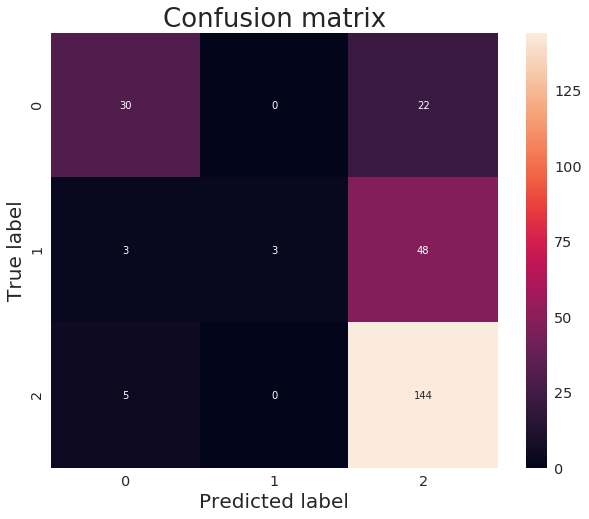

In [29]:
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

In [30]:
knn_prfs_score = precision_recall_fscore_support(y_test, knn_pred)
knn_df = pd.DataFrame(data={'Precision': knn_prfs_score[0], 'Recall': knn_prfs_score[1], 
                            'F1 score': knn_prfs_score[2], 'Support': knn_prfs_score[3]},
                      columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1, 2])

results = (knn_df.style.set_table_styles(styles))
results

,Precision,Recall,F1 score,Support
0,0.789474,0.576923,0.666667,52
1,1,0.0555556,0.105263,54
2,0.672897,0.966443,0.793388,149
